1. Токинизировать каждый документ - разделить на слова
2. Каждому слову присвоить индекс, оставив 0 и 1 для паддинга и неизвестных слов
3. Конвертировать документы в цифровой формат
4. Цифровой формат готов к подаче в NN

In [2]:
!git clone https://huggingface.co/microsoft/deberta-large

Cloning into 'deberta-large'...
Filtering content:  66% (2/3), 1.51 GiB | 5.46 MiB/s
Filtering content:  66% (2/3), 3.02 GiB | 10.79 MiB/s
Filtering content: 100% (3/3), 3.02 GiB | 10.79 MiB/s
Filtering content: 100% (3/3), 3.02 GiB | 10.69 MiB/s, done.


In [1]:
import math
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import numpy as np
import os
import gensim
import torch
import sentence_transformers
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn

from transformers import BertTokenizer, BertModel, pipeline, BartModel
from transformers import RobertaTokenizer, RobertaModel, AutoConfig, RobertaConfig
from transformers import AutoTokenizer, AutoModel

from sentence_transformers.util import cos_sim
from sentence_transformers import SentenceTransformer, models
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F

from collections import OrderedDict

import textstat

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
def load_model(model_name, dropout=True):
    
    if not dropout:
        configuration = load_config(model_name)
    
    if model_name == 'roberta-base':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        embeddings_model = RobertaModel.from_pretrained('roberta-base', config=configuration)
    
    elif model_name == 'bert-base-uncased':
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        embeddings_model = BertModel.from_pretrained('bert-base-uncased', config=configuration)
        
    elif model_name == 'roberta-large':
        tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
        embeddings_model = RobertaModel.from_pretrained('roberta-large', config=configuration)
        
    elif model_name == 'all-mpnet-base-v2':
        tokenizer = AutoTokenizer.from_pretrained('all-mpnet-base-v2')
        embeddings_model = AutoModel.from_pretrained('all-mpnet-base-v2')
        
    else:
        raise 'Model name not recognized'
    
#     summarizer = pipeline("summarization", model="bart-large-cnn")
    
    print(f'Model {model_name} is set')
    
    return tokenizer, embeddings_model   
    
def load_config(model_name):
    
    configuration = AutoConfig.from_pretrained(model_name)

    configuration.hidden_dropout_prob = 0.0
    configuration.attention_probs_dropout_prob = 0.0
    configuration.classifier_dropout = 0.0
    
    print('Dropout layers set to zero')
    
    return configuration

In [4]:
model_name = 'roberta-base'

# tokenizer, embeddings_model = load_model('bert-base-uncased', dropout=False)

# tokenizer, embeddings_model = load_model('all-mpnet-base-v2', dropout=True)

tokenizer, embeddings_model = load_model(model_name, dropout=False)

Dropout layers set to zero


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model roberta-base is set


# Objects and functions

In [5]:
summaries_train_path = r"dataset\summaries_train.csv"
summaries_test_path = r"dataset\summaries_test.csv"
prompts_train_path = r"dataset\prompts_train.csv"
prompts_test_path = r"dataset\prompts_test.csv"

In [6]:
def norm_score(df: pd.DataFrame) -> pd.DataFrame:
    """Normilizing score to values 0 to 1"""
    df -= np.min(df)
    df /= df.max()
    print('Normilized' if df.min() == 0.0 and df.max() == 1.0 else 'NormError:wrong values')
    
    return df

def short_text(text, max_length=400) -> str:
    if len(text.split()) > 700:
        middle_point = text[len(text)//2:].index('.') + len(text)//2 + 1
        text_pt1 = text[:middle_point]
        text_pt2 = text[middle_point:]
        
        text = short_text(text_pt1) + short_text(text_pt2)
        
    summarized = summarizer(text, max_length=max_length, min_length=200, do_sample=False)
    
    return summarized[0]['summary_text']

def moving_average(array: np.array, betta=0.9) -> np.array:
    """
    Computing moving average with bias correction.
    """
    
    V = 0
    average_array = np.zeros(len(array))
    for i in range(len(array)):
        V = betta * V + (1 - betta) * array[i]
        average_array[i] = V/(1 - pow(betta, i+1))
        
    return average_array



def mean_pooling(outputs, batch) -> torch.tensor:
    
    attention_mask = batch['attention_mask']
    embeddings = outputs.last_hidden_state
    
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    
    summed = torch.sum(masked_embeddings, 1)
    summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
    
    mean_pooled = summed/summed_mask
    
    return mean_pooled

def normilize(df_column: pd.DataFrame):
    
    df_column = (df_column - df_column.mean())/df_column.std()
    
    return df_column

def get_stat_features(df, text_col="text"):
    
    df["num_unique_words"] = normilize(df[text_col].apply(lambda x: len(set(x.split()))))
    df["num_words"] = normilize(df[text_col].apply(lambda x: len(x.split())))
    df["num_sentences"] = normilize(df[text_col].apply(lambda x: len(x.split('.'))))
    
    df["syntax_count"] = normilize(df[text_col].apply(lambda x: x.count(",") 
                                                      + x.count("-") + x.count(";") + x.count(":")))
    df['smog_index'] = normilize(df[text_col].apply(lambda x: textstat.smog_index(x)))
    
    
    return df

In [7]:
# All data

class SentenseData(Dataset):
    """
    :params: path to csv file with summaries, path to csv file with prompts, 'score' param\
    defines which score is used: content/wording
    """
    def __init__(self, summaries_path=summaries_train_path,
                 prompts_path=prompts_train_path,
                 score='content'):
        
        with open(summaries_path, encoding='utf-8') as f:
            summaries = pd.read_csv(f)
            summaries = get_stat_features(summaries)
            
            self.summaries = summaries
            
        with open(prompts_path, encoding='utf-8') as f:
            self.prompts = pd.read_csv(f)
        
        self.score_type = score
        
    def __len__(self):
        return len(self.__summaries)
    
    @property
    def summaries(self):
        return self.__summaries
    
    @summaries.setter
    def summaries(self, df):
        self.__summaries = df

    @property
    def prompts(self):
        return self.__prompts
    
    @prompts.setter
    def prompts(self, file):
        self.__prompts = file
    
    def get_batch_text(self, index):
        summary_text = self.summaries.text[index]

        res = tokenizer(summary_text, padding='max_length', return_tensors='pt', truncation=True)
        res = {k:val.squeeze() for k, val in res.items()}
        res['features'] = torch.tensor([self.summaries['num_unique_words'][index], self.summaries['num_words'][index],
                                  self.summaries['num_sentences'][index],self.summaries['syntax_count'][index],
                                  self.summaries['smog_index'][index]], dtype=torch.float32)
            
        return res
        
    def get_score(self, index):
        if self.score_type == 'content':
            score = self.summaries.content[index]
            
        elif self.score_type == 'wording':
            score = self.summaries.wording[index]
        
        return torch.tensor(score)
        
    def __getitem__(self, index) -> torch.tensor:

        batch_text = self.get_batch_text(index)
        batch_score = self.get_score(index)
        
        return batch_text, batch_score

In [7]:
# class SentenseData(Dataset):
#     """
#     :params: path to csv file with summaries, path to csv file with prompts, 'score' param\
#     defines which score is used: content/wording
#     """
#     def __init__(self, summaries_path=summaries_train_path,
#                  prompts_path=prompts_train_path,
#                  score='content', test=False):
#         self.test = test
        
#         with open(summaries_path, encoding='utf-8') as f:
#             self.summaries = pd.read_csv(f)
            
#         with open(prompts_path, encoding='utf-8') as f:
#             self.prompts = pd.read_csv(f)
        
# #         self.summaries.content = norm_score(self.summaries.content)
# #         self.summaries.wording = norm_score(self.summaries.wording)
        
#         self.score_type = score
        
#     def __len__(self):
#         return len(self.__summaries)
    
#     @property
#     def summaries(self):
#         return self.__summaries
    
#     @summaries.setter
#     def summaries(self, df):
#         if self.test:
#             self.__summaries = df[df.prompt_id == '39c16e'].reset_index(drop=True)
            
#         else:
#             self.__summaries = df[df.prompt_id != '39c16e'].reset_index(drop=True)
    
#     @property
#     def prompts(self):
#         return self.__prompts
    
#     @prompts.setter
#     def prompts(self, file):
#         self.__prompts = file
# #         for i, text in enumerate(self.__prompts.prompt_text):
# #             if len(text.split()) > 600:
# #                 self.__prompts.prompt_text[i] = short_text(text)
    
#     def get_batch_text(self, index):
#         summary_text = self.summaries.text[index]
        
#         if True:#self.score_type == 'wording':
#             res = tokenizer(summary_text, padding='max_length', return_tensors='pt', truncation=True)
#             return {k:val.squeeze() for k, val in res.items()}
        
#         prompt_text = self.prompts.prompt_text[self.prompts.prompt_id ==
#                                                self.summaries.prompt_id[index]].item().replace('\n','')
        
#         return tokenizer([summary_text, prompt_text], padding='max_length', return_tensors='pt', truncation=True)
    
#     def get_score(self, index):
#         if self.score_type == 'content':
#             score = self.summaries.content[index]
            
#         elif self.score_type == 'wording':
#             score = self.summaries.wording[index]
        
#         return torch.tensor(score)
        
#     def __getitem__(self, index) -> torch.tensor:

#         batch_text = self.get_batch_text(index)
#         batch_score = self.get_score(index)
        
#         return batch_text, batch_score

In [8]:
# class CosineSimilarityLoss(nn.Module):
#     def __init__(self):
#         super(CosineSimilarityLoss, self).__init__()
#         self.loss_func = nn.MSELoss()
#         self.identity = nn.Identity()
#         self.cos_sim = nn.CosineSimilarity(dim=1)
        
#     def forward(self, x, y):
#         embedding_1 = torch.stack([sentence[0] for sentence in x])
#         embedding_2 = torch.stack([sentence[1] for sentence in x])
        
#         cos_score = self.cos_sim(embedding_1, embedding_2)
#         cos_score = self.identity(cos_score)
        
#         loss = self.loss_func(x, y)
        
#         return loss

In [8]:
# Реализовать батч лоадер, возвращающий с каждой итерацией батч - лист с bs количеством словарей 
# Нужно, чтобы умел с шафлом

class BatchLoader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, drop=False):
#         super(BatchLoader, self).__init__()
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop = drop
        self.dataset_len = len(dataset)
        
    def __len__(self):
        return math.ceil(self.dataset_len/self.batch_size)
    
    def __iter__(self):
        self.index = list(range(self.dataset_len))
        if self.shuffle:
            np.random.shuffle(self.index)
        return self
    
    def __next__(self):
        batch_index = []
        
        if self.batch_size >= len(self.index):
            if self.drop or not self.index:
                raise StopIteration
            else:
                batch_index = self.index.copy()
                self.index.clear()
        else:
            for _ in range(self.batch_size):
                batch_index.append(self.index.pop())
        
        batch = []
        target = []
        
        for i in batch_index:
            batch.append(self.dataset[i][0])
            target.append(self.dataset[i][1])
            
        return batch, torch.tensor(target)
    
    def __getitem__(self, index):
        batch = self.dataset[index][0]
        target = self.dataset[index][1]
        
        return batch, target

In [13]:
class STSBertModel(nn.Module):
    """
    Sentence Semantic Similarity Bert model
    :param: seg_head=True for using segmentation head instead of cosine similarity
    :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
    """
    def __init__(self, with_features=False, input_size=768):
        super(STSBertModel, self).__init__()

        self.word_embedding = RobertaModel.from_pretrained(model_name, config=load_config(model_name))
        self.cos_score = nn.CosineSimilarity(dim=0)
        self.identity = nn.Identity()
        self.input_size = input_size
        self.with_features = with_features

        if with_features:
            self.n_features = 5
            self.input_size += self.n_features

        self.attention = SelfAttention(self.input_size)

        self.FC_head = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(self.input_size, 512)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(512, 512)),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(512, 256)),
            ('relu3', nn.ReLU()),
            ('fc4', nn.Linear(256, 64)),
            ('relu4', nn.ReLU()),
            ('fc5', nn.Linear(64, 1)),
            ('identity', nn.Identity())
            ]))

    def forward(self, x):
        output = self.word_embedding(input_ids=x['input_ids'], attention_mask=x['attention_mask'])
        output = mean_pooling(output, x)

        if self.with_features:
            output = torch.cat((output, x['features']), dim=1)

        output = self.attention(output.unsqueeze(1))
        output = self.FC_head(output)
        
        return output

In [10]:
# # MOdel without features

# class STSBertModel(nn.Module):
#     """
#     Sentence Semantic Similarity Bert model
#     :param: seg_head=True for using segmentation head instead of cosine similarity
#     :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
#     """
#     def __init__(self, seg_head=False, freeze_weights=False, input_size=768):
#         super(STSBertModel, self).__init__()
        
#         self.word_embedding = embeddings_model
#         self.cos_sim = nn.CosineSimilarity(dim=0)
#         self.identity = nn.Identity()
#         self.seg_head = seg_head
#         self.input_size = input_size
        
#         self.attention = SelfAttention(self.input_size)
#         self.FC_head = nn.Sequential(OrderedDict([
#             ('fc1', nn.Linear(self.input_size, 1))
#         ]))
            
#         if freeze_weights:
#             self.freeze()
    
#     def freeze(self):
#         for param in self.word_embedding.parameters():
#             param.requires_grad = False
    
#     def cos_score(self, x):
#         embedding_1 = x[0]
#         embedding_2 = x[1]
        
#         res = self.cos_sim(embedding_1, embedding_2)
# #         cos_score = torch.sigmoid(cos_score)

#         return res
    
#     def forward(self, x):
#         output = self.word_embedding(**x)
#         output = mean_pooling(output, x)
#         output = self.attention(output.unsqueeze(1))

# #         output = self.attention(output[0])
# #         output = torch.mean(output, dim=1)
# #         output = torch.max(output, dim=1).values
    
#         if self.seg_head:            
#             output = self.FC_head(output)
        
#         else:
#             output = self.cos_score(output)
#             output = (output * 6.1) - 1.8
        
#         return output

In [9]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted
    

In [12]:
# class STSBertModel(nn.Module):
#     """
#     Sentence Semantic Similarity Bert model
#     :param: seg_head=True for using segmentation head instead of cosine similarity
#     :param: freeze_weights=True to freeze BERT model's weights and train only the segmentation head
#     """
#     def __init__(self, seg_head=False, freeze_weights=False, input_size=768):
#         super(STSBertModel, self).__init__()
        
#         self.word_embedding = embeddings_model
#         self.cos_sim = nn.CosineSimilarity(dim=0)
#         self.identity = nn.Identity()
#         self.seg_head = seg_head
#         self.fc = nn.Sequential(OrderedDict([
#             ('fc1', nn.Linear(input_size*2, 1024)),
#             ('tanh', nn.Tanh()),
#             ('fc2', nn.Linear(1024, 256)),
#             ('tanh', nn.Tanh()),
#             ('output', nn.Linear(256, 1)),
#         ]))
        
        
#         if seg_head:
# #             self.FC_head = SbertHead(inputs=768)
#             self.FC_head = nn.Sequential(OrderedDict([
# #                 ('dropout1', nn.Dropout(0.2)),
#                 ('fc_input', nn.Linear(input_size, 1024)),
#                 ('relu1', nn.ReLU()),
#                 ('fc1', nn.Linear(1024,1024)),
# #                 ('dropout2', nn.Dropout(0.2)),
# #                 ('batch_norm1', nn.BatchNorm1d(1024)),
#                 ('relu2', nn.ReLU()),
#                 ('fc2', nn.Linear(1024, 512)),
#                 ('relu3', nn.ReLU()),
# #                 ('dropout2', nn.Dropout(0.2)),
#                 ('fc3', nn.Linear(512, 512)),
# #                 ('batch_norm2', nn.BatchNorm1d(512)),
#                 ('relu4', nn.ReLU()),
#                 ('fc4', nn.Linear(512, 256)),
# #                 ('batch_norm3', nn.BatchNorm1d(256)),
#                 ('relu5', nn.ReLU()),
# #                 ('dropout3', nn.Dropout(0.2)),
#                 ('fc5', nn.Linear(256, 64)),
#                 ('relu6', nn.ReLU()),
#                 ('fc_output', nn.Linear(64, 1))
# #                 ('activation', nn.Sigmoid())
#             ]))
            
#         if freeze_weights:
#             self.freeze()
    
#     def freeze(self):
#         for param in self.word_embedding.parameters():
#             param.requires_grad = False
    
#     @staticmethod
#     def mean_pooling(outputs, batch) -> torch.tensor:
        
#         attention_mask = batch['attention_mask']
#         embeddings = outputs.last_hidden_state
    
#         mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
#         masked_embeddings = embeddings * mask
    
#         summed = torch.sum(masked_embeddings, 1)
#         summed_mask = torch.clamp(mask.sum(dim=1), min=1e-9)
    
#         mean_pooled = summed/summed_mask
    
#         return mean_pooled
    
#     def cos_score(self, x):
#         embedding_1 = x[0]
#         embedding_2 = x[1]
#         emb = torch.concat((embedding_1, embedding_2))
        
        
        
#         cos_score = self.fc(emb)
        
# #         cos_score = self.cos_sim(embedding_1, embedding_2)
# #         cos_score = torch.sigmoid(cos_score)
        
#         return cos_score
    
#     def forward(self, x):
#         output = self.word_embedding(**x)
#         output = self.mean_pooling(output, x)
# #         output = output[1]
        
#         if self.seg_head:
#             output = self.FC_head(output)
        
#         else:
#             output = self.cos_score(output)
        
#         return output

In [11]:
# # Полносвязная модель - принимает тензор с эмбедингами текстов
# # Выдает 1 число [0, 1]

# class SbertHead(nn.Module):
#     def __init__(self, inputs=1024):
#         super(SbertHead, self).__init__()
        
#         self.FC_input = nn.Linear(inputs, 1024)
#         self.FC_hidden_0 = nn.Linear(1024, 1024)
#         self.FC_hidden_1 = nn.Linear(1024, 512)
#         self.FC_hidden_2 = nn.Linear(512, 512)
#         self.FC_hidden_3 = nn.Linear(512, 256)
#         self.FC_hidden_4 = nn.Linear(256, 64)
#         self.FC_output = nn.Linear(64, 1)
#         self.activation = nn.Sigmoid()
#         self.batch_norm = nn.BatchNorm1d(1024)
#         self.batch_norm_2 = nn.BatchNorm1d(512)
#         self.batch_norm_3 = nn.BatchNorm1d(64)

#     def forward(self, x: torch.tensor) -> torch.tensor:
        
#         x = F.relu(self.FC_input(x))
#         x = F.relu(self.FC_hidden_0(x))
#         x = self.batch_norm(x)
#         x = F.relu(self.FC_hidden_1(x))
#         x = F.relu(self.FC_hidden_2(x))
#         x = self.batch_norm_2(x)
#         x = F.relu(self.FC_hidden_3(x))
#         x = F.relu(self.FC_hidden_4(x))
#         x = self.batch_norm_3(x)
        
#         x = self.FC_output(x)
#         x = self.activation(x)

#         return x

# Data loading

In [10]:
score_type = 'wording'

train_data = SentenseData(score=score_type)
# test_data = SentenseData(test=True, score=score_type)
# train_data = SentenseData(score=score_type)

In [11]:
batch_size = 15


train_loader = DataLoader(train_data,
                           batch_size=batch_size,
                           shuffle=True)

# test_loader = DataLoader(test_data,
#                           batch_size=batch_size,
#                           shuffle=True)

In [15]:
# dataset = SentenseData(summaries_train_path, prompts_train_path)

In [17]:
# train_size = int(0.8*len(dataset))
# test_size = len(dataset) - train_size

# train_data, test_data = random_split(dataset, [train_size, test_size])

# # torch.save(train_data, 'dataset\TRAIN_DATA_split_1.pt')
# # torch.save(test_data, 'dataset\TEST_DATA_split_1.pt')

In [16]:
# train_data = torch.load('dataset\TRAIN_DATA_split_1.pt')
# test_data = torch.load('dataset\TEST_DATA_split_1.pt')

In [10]:
batch_size = 8

train_loader = BatchLoader(train_data,
                           batch_size=batch_size,
                           shuffle=True)

test_loader = BatchLoader(test_data,
                          batch_size=batch_size,
                          shuffle=True)

## Model Train

In [14]:
model = STSBertModel(with_features=True)

Dropout layers set to zero


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model.float()

model.to(device)

STSBertModel(
  (word_embedding): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [16]:
params = [
        {'params': model.word_embedding.parameters()},
        {'params': model.attention.parameters(), 'lr': 1e-04},
        {'params': model.FC_head.parameters(), 'lr': 2e-04}
    ]

Loss_func = nn.MSELoss()

optimizer = torch.optim.AdamW(params, lr=2e-06, weight_decay=2e-02)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

scaler = torch.cuda.amp.GradScaler()

In [46]:
del  outputs, targets, optimizer, Loss_func, lr_scheduler, model, scaler

In [24]:
torch.cuda.empty_cache()

In [23]:
import gc

gc.collect()

1297

In [17]:
def validate_model():

    losses_epoch_test = []
    
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, position=0, leave=True):
            targets = targets.float().to(device)
            
            if True:#score_type == 'wording':
                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}
                outputs = model(inputs)
                
                loss = torch.sqrt(Loss_func(outputs.squeeze(), targets))
            else:
                outputs = torch.stack([model(sentence.to(device)) for sentence in inputs])              
                loss = torch.sqrt(Loss_func(outputs, targets))

            
            losses_epoch_test.append(loss.item())
    
    return losses_epoch_test


n_epochs = 5

losses_train = []
losses_test = []
t0 = datetime.now()

for i in range(n_epochs):
    
    losses_train_per_epoch = []
    
    for j, batch in enumerate(tqdm(train_loader, position=0, leave=True), 1):
        inputs, targets = batch
        targets = targets.float().to(device)
        
        model.train()
        
        optimizer.zero_grad()
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            if True:#score_type == 'wording':
                inputs = {k:val.squeeze().to(device) for k, val in inputs.items()}
                outputs = model(inputs)
                loss = torch.sqrt(Loss_func(outputs.squeeze(), targets))
            else:
                outputs = torch.stack([model(sentence.to(device)) for sentence in inputs])           
                loss = torch.sqrt(Loss_func(outputs, targets))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()
        
        losses_train_per_epoch.append(loss.item())
        
#         if j%20 == 0 or j == len(train_loader):
            
#             losses_test_per_epoch = validate_model()
#             losses_test_mean = np.mean(losses_test_per_epoch)
#             losses_train_mean = np.mean(losses_train_per_epoch)
            
#             losses_train.append(losses_train_mean)
#             losses_test.append(losses_test_mean)
            
            
#             if losses_test_mean == np.min(losses_test):
#                 best_score = losses_test_mean
#                 n_iter = len(losses_train)
#                 torch.save(model.state_dict(), 'best__.pt')
#                 print(f'Best saved, loss: {best_score:.5f}')
                
    print(f'Epoch: {i+1}/{n_epochs}, Iter: {len(losses_train)}, L_train: {np.mean(losses_train_per_epoch):.5f}')#,\
            #L_test: {losses_test_mean:.5f}') 
            
    torch.cuda.empty_cache()

#print(f"Time elapsed:{datetime.now()-t0}, Best score:{best_score:.5f} at {n_iter} iteration")

100%|██████████| 478/478 [01:37<00:00,  4.89it/s]


Epoch: 1/5, Iter: 0, L_train: 0.67062


100%|██████████| 478/478 [01:36<00:00,  4.94it/s]


Epoch: 2/5, Iter: 0, L_train: 0.56503


100%|██████████| 478/478 [01:36<00:00,  4.93it/s]


Epoch: 3/5, Iter: 0, L_train: 0.52126


100%|██████████| 478/478 [01:36<00:00,  4.95it/s]


Epoch: 4/5, Iter: 0, L_train: 0.48913


100%|██████████| 478/478 [01:36<00:00,  4.95it/s]

Epoch: 5/5, Iter: 0, L_train: 0.46103


In [18]:
np.mean(losses_train_per_epoch)

0.48831519858607686

In [18]:
torch.save(model.state_dict(), 'models\Roberta_base_feat_wording_10.pt')

In [26]:
count = 0
for i in range(511):
    if i%64 == 0:
        count+=1
        
count

8

Text(0.5, 1.0, 'Min value: 0.45780')

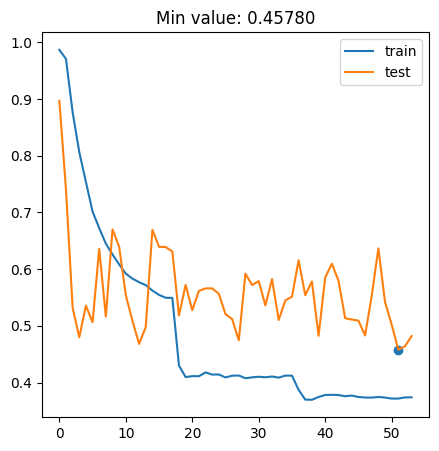

In [26]:
plt.figure(figsize=(5,5))

plt.plot(losses_train, label = 'train')
plt.plot(losses_test, label='test')
plt.scatter(n_iter - 1, best_score, marker='o')
plt.legend()
plt.title(f'Min value: {best_score:.5f}')


In [23]:
losses_epoch_test = []
rmse = []

for inputs, targets in tqdm(test_loader):
    targets = targets.float().to(device)
            
    outputs = torch.stack([model(sentence.to(device)) for sentence in inputs])
    
    error = np.sqrt(sum((outputs.cpu().detach() - targets.cpu().detach())**2)/len(targets))
    
    loss = Loss_func(outputs.squeeze(), targets)
            
    losses_epoch_test.append(loss.item())
    rmse.append(error)
    
np.mean(losses_epoch_test)
np.mean(rmse)

100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [10:32<00:00,  1.57s/it]


0.12578605

In [19]:
np.mean(losses_epoch_test)

0.6657895640186642

In [28]:
outputs.squeeze()

tensor([ 0.8711,  1.4131,  0.3809, -0.2595, -1.4795,  0.0757,  0.0840,  0.8584],
       device='cuda:0', dtype=torch.float16, grad_fn=<SqueezeBackward0>)

In [29]:
targets

tensor([ 0.5038,  1.1258,  1.2163, -0.2051, -1.4612, -0.0493,  0.3805,  1.3874],
       device='cuda:0')

In [30]:
sum((outputs.squeeze() - targets)**2)/len(targets)

tensor(0.1628, device='cuda:0', grad_fn=<DivBackward0>)

In [31]:
torch.save(model.state_dict(), 'models\RoBerta_wording_2l.pt')

Text(0.5, 1.0, 'Min value: 0.53558')

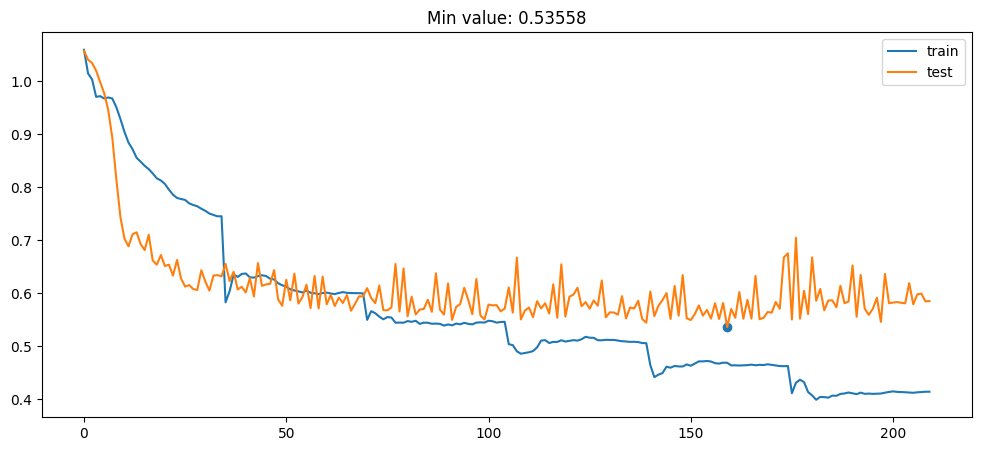

In [20]:
best_score

0.5457825397235759

In [306]:
# Вычисляем cos similarity для всех сочинений по первому тексту

y_all = np.zeros(len(dataset))
y_hat_all = y_all.copy()
model.eval()

for i in range(len(dataset)):
    batch = dataset[i]

    outputs = model(**batch[0].to(device))
    y = batch[1].item()
    sentense_embeddings = mean_pooling(outputs, batch)
    
    pooled_numpy = sentense_embeddings.cpu().detach().numpy()
    y_hat = cosine_similarity(np.expand_dims(pooled_numpy[0],0), np.expand_dims(pooled_numpy[1],0))
    
    y_all[i] = y
    y_hat_all[i] = y_hat
    
del batch    
torch.cuda.empty_cache()

Text(0.5, 1.0, 'Cosine simularity')

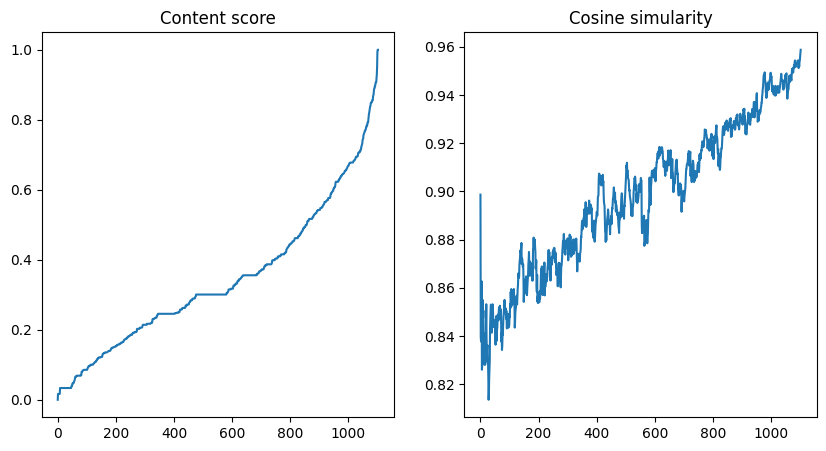

In [318]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(y_all)
plt.title('Content score')

plt.subplot(1,2,2)
plt.plot(moving_average(y_hat_all))
plt.title('Cosine simularity')

In [13]:
answer_1_tokenized = tokenizer(answer_1_summary)['input_ids']
sim_score = np.zeros(len(df_summaries_sorted))
len_answer = len(answer_1_tokenized)

for i, text in enumerate(df_summaries_sorted.text):
    text_tokenized = tokenizer(text)['input_ids']
    len_dif = len_answer - len(text_tokenized)
    answer = answer_1_tokenized.copy()
    
#     print(len_answer, len(text_tokenized), len_dif)
    if len_dif > 0:
        text_tokenized += [0]*len_dif
    
    elif len_dif < 0:
        answer += [0]*abs(len_dif)
    
    answer = torch.tensor(answer).float()
#     print(len_answer, len(text_tokenized), len_dif, answer.shape)    
    text_tokenized = torch.tensor(text_tokenized).float()
    
    sim = cos_sim(answer, text_tokenized)
    
    sim_score[i] = 1 - sim.item()

Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


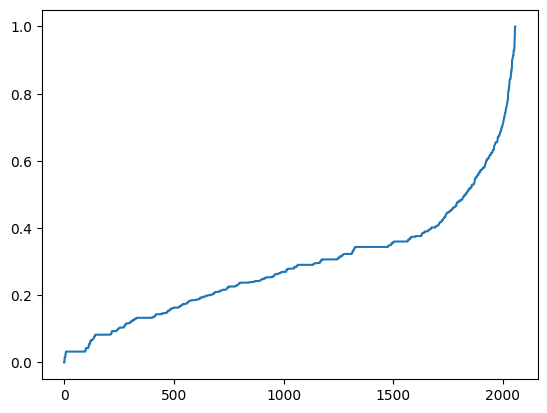

In [48]:
plt.plot(df_summaries_sorted.content)

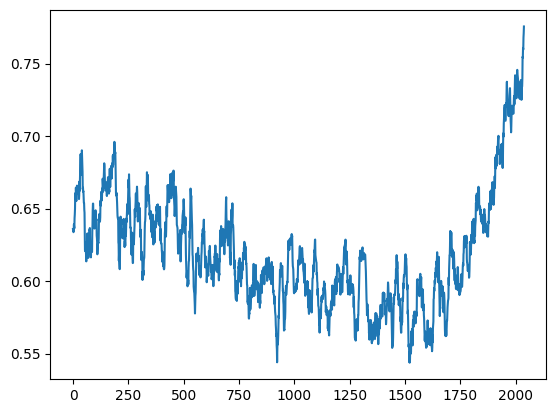

In [19]:
# Предсказанная похожесть текстов сочинений и ответа
plt.plot(moving_average(sim_score))

In [ ]:
n_epochs = 9
losses_train = np.zeros(n_epochs)
losses_test = np.zeros(n_epochs)
accuracy = np.zeros(n_epochs)

for i in range(n_epochs):
    model.train()
    losses_epoch_train = []
    
    t0 = datetime.now()
    
    for inputs, targets in tqdm(train_loader):

        targets = targets.float().to(device)
        
        
        optimizer.zero_grad()
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            if score_type == 'wording':
                inputs = {k:val.to(device) for k, val in inputs.items()}
                outputs = model(inputs)
            
            else:
#                 inputs = inputs.to(device)
                outputs = torch.stack([model(sentence.to(device)) for sentence in inputs])
#             outputs = torch.concat([model(sentence.to(device)) for sentence in inputs])
            
            loss = torch.sqrt(Loss_func(outputs.squeeze(), targets))
    
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        
        scaler.update()
        
        losses_epoch_train.append(loss.item())
    
    lr_scheduler.step()
    
    losses_epoch_test = []
#     acc = []

    
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            targets = targets.float().to(device)
            
            
            if score_type == 'wording':
#                 input_ids = inputs['input_ids'].to(device)
#                 attention_mask = inputs['attention_mask'].to(device)
                inputs = {k:val.to(device) for k, val in inputs.items()}
                outputs = model(inputs)
        
            else:
#                 inputs = inputs.to(device)
                outputs = torch.stack([model(sentence.to(device)) for sentence in inputs])
#             outputs = torch.concat([model(sentence.to(device)) for sentence in inputs])

            loss = torch.sqrt(Loss_func(outputs.squeeze(), targets))

            
            losses_epoch_test.append(loss.item())
        
#     accuracy[i] = np.mean(acc)
    losses_train[i] = np.mean(losses_epoch_train) 
    losses_test[i] = np.mean(losses_epoch_test)
    
    if np.mean(losses_epoch_test) == np.min(losses_test[:i+1]):
        torch.save(model.state_dict(), 'best__.pt')
        print(f'Best saved, loss: {np.mean(losses_epoch_test):.3f}')
     
    if n_epochs > 100 and i == 100:
        torch.save(model.state_dict(), '100_epochs__.pt')
        print(f'100 epochs weights saved!')
        
    dt = datetime.now() - t0
    
    print(f'Epoch: {i+1}/{n_epochs}, L_train: {losses_train[i]:.5f}\
    L_test: {losses_test[i]:.5f}, Time: {dt}, acc: {accuracy[i]:.3f}') 
    
    torch.cuda.empty_cache()